<a href="https://colab.research.google.com/github/Jatin-Khiyani/Visual-Situmlai-Reconstruction-Using-fMRI-and-Deep-Learning/blob/main/Image%20Generation/Reconstruction_of_Image_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement


We will be trying to generate images by using stable diffusion models based on the fMRI to VQ-VAE Image and fMRI to CLIP Captions models we have already made

Diffusion models itterativly remove noise from a image with only noise to generate a new image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importing Libraries

In [ ]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",  device)

Using device: cuda


# Setting Enviornment


In [ ]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.to(device).eval()
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
unet.to(device).eval()
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
text_encoder.to(device).eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ─── Ridge Dual Model ────────────────────────────────────────────────────────
class RidgeDual:
    def __init__(self, alpha=1.0, device=None):
        self.alpha = alpha
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.W = None
        self.b = None

    def fit(self, X_np, Y_np):
        X = torch.from_numpy(X_np).float().to(self.device)
        Y = torch.from_numpy(Y_np).float().to(self.device)

        N, D = X.shape

        K = X @ X.T  # Kernel matrix
        A = torch.linalg.solve(
            K + self.alpha * torch.eye(N, device=self.device),
            Y
        )

        self.W = X.T @ A  # (D, T)
        self.b = torch.zeros(Y.shape[1], device=self.device)  # No need if using scaled targets

    def predict(self, X_np, chunk_size=None):
        X = torch.from_numpy(X_np).float().to(self.device)
        if chunk_size is None:
            return (X @ self.W + self.b).cpu().numpy()

        outs = []
        for start in tqdm(range(0, X.shape[0], chunk_size), desc="Predicting", unit="chunk"):
            chunk = X[start:start+chunk_size]
            out = chunk @ self.W + self.b
            outs.append(out.cpu().numpy())
        return np.vstack(outs)

In [ ]:
import joblib
scaler_z= joblib.load("/content/drive/MyDrive/NSD_Dataset/scaler_Z.joblib")
scaler_c = joblib.load("/content/drive/MyDrive/NSD_Dataset/scaler_C.joblib")

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
import joblib
model_fz = joblib.load('/content/drive/MyDrive/NSD_Dataset/model_f_z.joblib')
model_fc = joblib.load('/content/drive/MyDrive/NSD_Dataset/model_f_c.joblib')
X = np.load('/content/drive/MyDrive/NSD_Dataset/fmri.npy')
X = X.reshape(X.shape[0], -1)
# Predict normalized outputs
z_norm = model_fz.predict(X)      # (27750, 16384)
c_norm = model_fc.predict(X)      # (27750, 11520)

# Inverse transform to original scale
z = scaler_z.inverse_transform(z_norm)  # final z (VQ-VAE latents)
c = scaler_c.inverse_transform(c_norm)  # final c (CLIP embeddings)

In [ ]:
import torch

# Pick a sample (e.g., the first image)
i = 0
z_flat_sample = z[i]         # shape (16384,)
c_flat_sample = c[i]         # shape (7680,) = 15 × 768

# Reshape z → [1, 4, 64, 64]
z_sample = torch.tensor(z_flat_sample, dtype=torch.float32).reshape(1, 4, 64, 64).to(device)

# Reshape c → [1, 77, 768] by padding up to 77 tokens
decoded_c = torch.tensor(c_flat_sample, dtype=torch.float32).reshape(1, 10, 768).to(device)
c_sample = torch.zeros(1, 77, 768).to(device)
c_sample[:, :10, :] = decoded_c


In [ ]:
from diffusers import LMSDiscreteScheduler
import torch

# Choose number of diffusion steps (same as used in training, usually 50)
num_inference_steps = 300
scheduler.set_timesteps(num_inference_steps)

# Pick final timestep (as Python int)
t = scheduler.timesteps[-1].item()

# Convert to batch-aligned tensor
t_batch = torch.tensor([t], dtype=torch.long).to(device)

# Add noise to z using scheduler
noise = torch.randn_like(z_sample)
z_T = scheduler.add_noise(original_samples=z_sample, noise=noise, timesteps=t_batch)



In [ ]:
# Make a copy of z_T to start the denoising chain
latent = z_T.clone()

# Loop through timesteps in reverse
for t in tqdm(scheduler.timesteps, desc="Denoising"):
    # Expand the latent batch (some schedulers expect this)
    latent_input = latent

    # Predict noise using UNet
    with torch.no_grad():
        noise_pred = unet(latent_input, t, encoder_hidden_states=c_sample).sample

    # Remove noise using scheduler step
    latent = scheduler.step(noise_pred, t, latent)["prev_sample"]
# --- Load your full train‐set arrays once at top of script:
Z_real_all = np.load("/content/drive/MyDrive/NSD_Dataset/z.npy")    # shape (N,16384)
Z_pred_all = z    # same shape

# 1) Compute per‐dim stats
mu_real =   Z_real_all.mean(axis=0)       # (16384,)
std_real =  Z_real_all.std(axis=0)        # (16384,)
mu_pred =   Z_pred_all.mean(axis=0)
std_pred =  Z_pred_all.std(axis=0)

# 2) Normalize your single prediction
z_p = z_flat_sample                         # (16384,)
z_norm = (z_p - mu_pred) * (std_real / std_pred) + mu_real

print(f"Per‐dim normalization done. norm mean/std = {z_norm.mean():.3f}/{z_norm.std():.3f}")

# 3) Reshape & VAE decode
z_tensor = torch.tensor(z_norm, dtype=torch.float32)\
                 .reshape(1, 4, 64, 64).to(device)

with torch.no_grad():
    dec = vae.decode(z_tensor / 0.18215).sample

# 4) Post‐process and save
img = (dec.clamp(-1,1) + 1)/2
from torchvision.transforms.functional import to_pil_image
to_pil_image(img.cpu().squeeze(0)).save("decoded_normed.png")
print("✅ Saved normalized decode to decoded_normed.png")

Denoising: 100%|██████████| 300/300 [00:33<00:00,  8.95it/s]


Per‐dim normalization done. norm mean/std = 0.112/0.862
✅ Saved normalized decode to decoded_normed.png


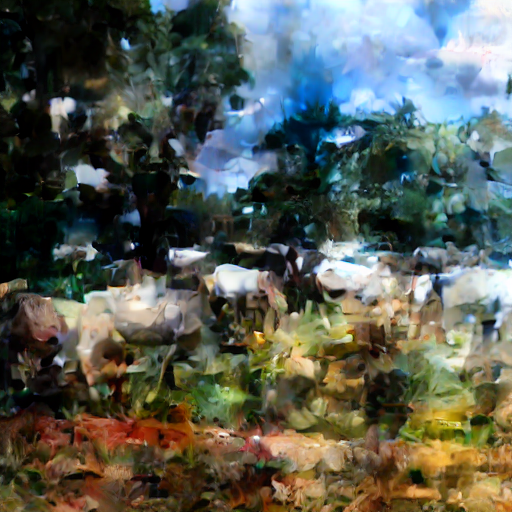

In [ ]:
from torchvision.transforms.functional import to_pil_image
from IPython.display import display

# remove the batch dimension
single = img.cpu().squeeze(0)          # now shape: (C, H, W)

# convert to PIL and display
image_pil = to_pil_image(single)
display(image_pil)

In [ ]:
# ================== DEBUG DIAGNOSTICS ==================

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 1. DEVICE & MODELS
print(f"\n[1] DEVICE: {device}")
print(f"[2] VAE loaded: {vae.__class__.__name__}")
print(f"    VAE eval mode: {vae.training == False}")

# 2. RAW PREDICTED LATENTS
# your predicted flat latent is z_flat_sample
print(f"\n[3] z_flat_sample (raw) shape: {z_flat_sample.shape}")
print(f"    min/max: {z_flat_sample.min():.4f}/{z_flat_sample.max():.4f}")
print(f"    mean/std: {z_flat_sample.mean():.4f}/{z_flat_sample.std():.4f}")

# plot raw latent histogram
plt.figure(figsize=(6,3))
plt.hist(z_flat_sample, bins=100, alpha=0.7)
plt.title("Raw z_flat_sample Distribution")
plt.show()

# 3. RESHAPE
z_raw = torch.tensor(z_flat_sample, dtype=torch.float32).reshape(1, 4, 64, 64).to(device)
print(f"\n[4] z_raw tensor shape: {tuple(z_raw.shape)}")
print(f"    z_raw min/max: {z_raw.min().item():.4f}/{z_raw.max().item():.4f}")
print(f"    z_raw mean/std: {z_raw.mean().item():.4f}/{z_raw.std().item():.4f}")

# 4. SCALE FOR DECODE
scale = 0.18215
z_scaled = z_raw / scale
print(f"\n[5] After dividing by {scale}:")
print(f"    z_scaled min/max: {z_scaled.min().item():.4f}/{z_scaled.max().item():.4f}")
print(f"    z_scaled mean/std: {z_scaled.mean().item():.4f}/{z_scaled.std().item():.4f}")

# overlay histograms raw vs scaled
plt.figure(figsize=(6,3))
plt.hist(z_raw.cpu().numpy().flatten(), bins=100, alpha=0.5, label="raw")
plt.hist(z_scaled.cpu().numpy().flatten(), bins=100, alpha=0.5, label="scaled")
plt.legend()
plt.title("Raw vs Scaled Latent Distribution")
plt.show()

# 5. VAE DECODE
vae.to(device).eval()
with torch.no_grad():
    dec_raw    = vae.decode(z_raw).sample
    dec_scaled = vae.decode(z_scaled).sample

print(f"\n[6] dec_raw shape: {tuple(dec_raw.shape)}")
print(f"    dec_scaled shape: {tuple(dec_scaled.shape)}")

# 6. POSTPROCESS & VISUALIZE
def postproc(x):
    x = (x.clamp(-1, 1) + 1) / 2
    return x

img_raw    = postproc(dec_raw).cpu().squeeze(0)
img_scaled = postproc(dec_scaled).cpu().squeeze(0)

# display side by side
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.transpose(img_raw.numpy(), (1,2,0)))
plt.title("Decoded from Raw Latent")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.transpose(img_scaled.numpy(), (1,2,0)))
plt.title("Decoded from Scaled Latent")
plt.axis('off')
plt.show()

# 7. (Optional) REAL LATENT COMPARISON
try:
    z_real = np.load("/content/drive/MyDrive/NSD_Dataset/z.npy")  # adjust path
    print(f"\n[7] z_real shape: {z_real.shape}")
    print(f"    real mean/std: {z_real.mean():.4f}/{z_real.std():.4f}")
    from sklearn.metrics import mean_squared_error
    import scipy.stats as st
    mse = mean_squared_error(z_real, z_flat_sample)
    rho = st.pearsonr(z_real, z_flat_sample)[0]
    print(f"    MSE vs real: {mse:.4f}")
    print(f"    Pearson ρ vs real: {rho:.4f}")
except Exception as e:
    print("\n[7] Skipping real–predicted comparison:", e)

# 8. DIFFUSION SCHEDULER & NOISE (if you use them)
if 'scheduler' in globals() and 'noise' in globals():
    print(f"\n[8] Scheduler timesteps: {len(scheduler.timesteps)}")
    print(f"    Noise tensor shape: {noise.shape}")
    print(f"    Noise mean/std: {noise.mean().item():.4f}/{noise.std().item():.4f}")


In [ ]:
import nbformat

# load your notebook
nb = nbformat.read("your_notebook.ipynb", as_version=4)

# remove any bad widget metadata
if "widgets" in nb.metadata:
    nb.metadata.pop("widgets")

# write out a clean copy
nbformat.write(nb, "your_notebook_clean.ipynb")


FileNotFoundError: [Errno 2] No such file or directory: 'your_notebook.ipynb'